In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import torch
import gc

#sns.set_style('darkgrid')
#sns.set_context('paper')
#plt.rcParams['figure.figsize'] = (17,7)
#plt.rcParams['font.size'] = 18

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
attr = pd.read_csv('/kaggle/input/vk-case/attr.csv')
train = pd.read_csv('/kaggle/input/vk-case/train.csv')

In [3]:
attr.head()

,ego_id,u,age,city_id,sex,school,university
0,0,227,68,-1,1,778293348,-1
1,0,45,38,237065842,1,82803468,238500268
2,0,142,60,237065842,1,196560139,-1
3,0,280,66,-1,2,963209731,720783270
4,0,41,18,-1,2,308862409,-1


In [4]:
train.head(3)

,ego_id,u,v,t,x1,x2,x3
0,0,131,84,148.0,5.669200e-07,0.0,0.0
1,0,135,164,396.7,6.246274e-02,0.0,0.0
2,0,47,15,NaN,0.000000e+00,0.0,1.0


### -> Создаем сэмплы

In [5]:
sampled_unique1 = np.random.choice(train['ego_id'].unique(), size=2000, replace=False)
# sampled_unique2 = np.random.choice(train['ego_id'].unique(), size=2000, replace=False)
# sampled_unique3 = np.random.choice(train['ego_id'].unique(), size=2000, replace=False)
# sampled_unique4 = np.random.choice(train['ego_id'].unique(), size=2000, replace=False)
# Фильтрация по выбранным уникальным ID
sampled_data1 = train[train['ego_id'].isin(sampled_unique1)]
# sampled_data2 = train[train['ego_id'].isin(sampled_unique2)]
# sampled_data3 = train[train['ego_id'].isin(sampled_unique3)]
# sampled_data4 = train[train['ego_id'].isin(sampled_unique4)]

### -> Теперь мержим эти сэмплы с атрибутами

In [6]:
def create_merge(df, attr):
    df = df.merge(attr, on=['ego_id', 'u'], how='left')
    df.rename(columns = {'age':'age_u', 'city_id':'city_id_u', 'sex':'sex_u',
                            'school':'school_u','university':'university_u',}, inplace = True )
    df = df.merge(attr, left_on=['ego_id', 'v'], right_on=['ego_id', 'u'], how='left')
    df.rename(columns = {'age':'age_v', 'city_id':'city_id_v', 'sex':'sex_v',
                            'school':'school_v','university':'university_v',}, inplace = True )
    df.rename(columns = {'u_x':'u'}, inplace = True )
    df = df.drop(columns = ['u_y'])
    
    return df

In [7]:
def not_nan_t(df):
    df['t'] = df['t'].fillna(-1)
    return df

In [8]:
sampled_data1 = create_merge(sampled_data1, attr)
# sampled_data2 = create_merge(sampled_data2, attr)
# sampled_data3 = create_merge(sampled_data3, attr)
# sampled_data4 = create_merge(sampled_data4, attr)

In [10]:
sampled_data1 = not_nan_t(sampled_data1)
# sampled_data2 = not_nan_t(sampled_data2)
# sampled_data3 = not_nan_t(sampled_data3)
# sampled_data4 = not_nan_t(sampled_data4)

### -> Избавляемся от выбросов age

In [9]:
def replace_with_mean_age(value):
    if (value > 70).any():
        return value.mean()
    else:
        return value

In [10]:
sampled_data1['age_u'] = sampled_data1.groupby('ego_id')['age_u'].transform(replace_with_mean_age)
sampled_data1['age_v'] = sampled_data1.groupby('ego_id')['age_v'].transform(replace_with_mean_age)

# sampled_data2['age_u'] = sampled_data2.groupby('ego_id')['age_u'].transform(replace_with_mean_age)
# sampled_data2['age_v'] = sampled_data2.groupby('ego_id')['age_v'].transform(replace_with_mean_age)

# sampled_data3['age_u'] = sampled_data3.groupby('ego_id')['age_u'].transform(replace_with_mean_age)
# sampled_data3['age_v'] = sampled_data3.groupby('ego_id')['age_v'].transform(replace_with_mean_age)

# sampled_data4['age_u'] = sampled_data4.groupby('ego_id')['age_u'].transform(replace_with_mean_age)
# sampled_data4['age_v'] = sampled_data4.groupby('ego_id')['age_v'].transform(replace_with_mean_age)

Пока что заполним значения NaN нулями

In [11]:
sampled_data1 = sampled_data1.fillna(0) # 0 - просто нет данных, хотя тут можно было поставить и -1
# sampled_data2 = sampled_data2.fillna(0)
# sampled_data3 = sampled_data3.fillna(0)
# sampled_data4 = sampled_data4.fillna(0)

### -> Преобразовываем айдишники школ, города и универа в расстояние между ними в численный признак

In [12]:
def dif_school(row):
    if row['school_u'] not in (-1, 0) and row['school_v'] not in (-1, 0):
        val = np.abs(row['school_u'] - row['school_v'])
    if row['school_u'] in (-1, 0) and row['school_v'] in (-1, 0):
        val = -1
    if row['school_u'] in (-1, 0) and row['school_v'] not in (-1, 0):
        val = row['school_v']
    if row['school_u'] not in (-1, 0) and row['school_v'] in (-1, 0):
        val = row['school_u']
    return val

def dif_city(row):
    if row['city_id_u'] not in (-1, 0) and row['city_id_v'] not in (-1, 0):
        val = np.abs(row['city_id_u'] - row['city_id_v'])
    if row['city_id_u'] in (-1, 0) and row['city_id_v'] in (-1, 0):
        val = -1
    if row['city_id_u'] in (-1, 0)and row['city_id_v'] not in (-1, 0):
        val = row['city_id_v']
    if row['city_id_u'] not in (-1, 0) and row['city_id_v'] in (-1, 0):
        val = row['city_id_u']
    return val


def dif_uni(row):
    if row['university_u'] not in (-1, 0) and row['university_v'] not in (-1, 0):
        val = np.abs(row['university_u'] - row['university_v'])
    if row['university_u'] in (-1, 0) and row['university_v'] in (-1, 0):
        val = -1
    if row['university_u'] in (-1, 0) and row['university_v'] not in (-1, 0):
        val = row['university_v']
    if row['university_u'] not in (-1, 0) and row['university_v'] in (-1, 0):
        val = row['university_u']
    return val

In [13]:
sampled_data1['dif_school'] = sampled_data1.apply(dif_school, axis=1)
sampled_data1['dif_city'] = sampled_data1.apply(dif_city, axis=1)
sampled_data1['dif_uni'] = sampled_data1.apply(dif_uni, axis=1)

# sampled_data2['dif_school'] = sampled_data2.apply(dif_school, axis=1)
# sampled_data2['dif_city'] = sampled_data2.apply(dif_city, axis=1)
# sampled_data2['dif_uni'] = sampled_data2.apply(dif_uni, axis=1)

# sampled_data3['dif_school'] = sampled_data3.apply(dif_school, axis=1)
# sampled_data3['dif_city'] = sampled_data3.apply(dif_city, axis=1)
# sampled_data3['dif_uni'] = sampled_data3.apply(dif_uni, axis=1)

# sampled_data4['dif_school'] = sampled_data4.apply(dif_school, axis=1)
# sampled_data4['dif_city'] = sampled_data4.apply(dif_city, axis=1)
# sampled_data4['dif_uni'] = sampled_data4.apply(dif_uni, axis=1)

### -> Ищем друзей каждого пользователя в рамках одного эго-графа. Затем коэффициент Жаккара - пересечение множеств друзей.

In [14]:
def friendship(sampled_data):

    sampled_data['u_w'] = ''
    sampled_data['v_w'] = ''
    from tqdm import tqdm

    ego_list = sampled_data['ego_id'].unique()
    sampled_data['u_w'] = sampled_data['u_w'].astype(object)
    sampled_data['v_w'] = sampled_data['v_w'].astype(object)

    for ego in tqdm(ego_list):
        temp = sampled_data[sampled_data["ego_id"] == ego]
        for i, (u, v) in enumerate(zip(temp["u"], temp["v"])):
            u_w1 = temp.loc[temp["v"] == u, "u"].dropna().values.tolist()
            u_w2 = temp.loc[temp["u"] == u, "v"].dropna().values.tolist()
            u_w = u_w1 + u_w2
            v_w1 = temp.loc[temp["u"] == v, "v"].dropna().values.tolist()
            v_w2 = temp.loc[temp["v"] == v, "u"].dropna().values.tolist()
            v_w = v_w1 + v_w2
            sampled_data.at[temp.index[i], 'u_w'] = u_w
            sampled_data.at[temp.index[i], 'v_w'] = v_w
    return sampled_data

In [15]:
%%time

sampled_data1 = friendship(sampled_data1)
# sampled_data2 = friendship(sampled_data2)
# sampled_data3 = friendship(sampled_data3)
# sampled_data4 = friendship(sampled_data4)


100%|██████████| 2000/2000 [1:09:07<00:00,  2.07s/it]

CPU times: user 1h 9min 1s, sys: 14 s, total: 1h 9min 15s
Wall time: 1h 9min 7s


In [16]:
def jaccard(u_w, v_w):
    intersection = len(list(set(u_w).intersection(v_w)))
    union = (len(u_w) + len(v_w)) - intersection
    return float(intersection) / union

In [17]:
sampled_data1['jac'] = sampled_data1.apply(lambda row: jaccard(row['u_w'], row['v_w']), axis=1)
# sampled_data2['jac'] = sampled_data2.apply(lambda row: jaccard(row['u_w'], row['v_w']), axis=1)
# sampled_data3['jac'] = sampled_data3.apply(lambda row: jaccard(row['u_w'], row['v_w']), axis=1)
# sampled_data4['jac'] = sampled_data4.apply(lambda row: jaccard(row['u_w'], row['v_w']), axis=1)

In [18]:
del train
gc.collect()

0

In [21]:
del attr
gc.collect()

NameError: name 'attr' is not defined

# Модель

In [22]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [23]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [24]:
X = sampled_data1.drop(["x1", 'u_w', 'v_w'], axis = 1)
y = sampled_data1['x1']

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state=42)

del X,y
gc.collect()

652

In [26]:
best_model = CatBoostRegressor(random_state=42, metric_period=100, verbose=False, depth=12, rsm=0.99, 
                             learning_rate=0.05, l2_leaf_reg=4.8, loss_function='RMSE', eval_metric='RMSE', bagging_temperature=4, one_hot_max_size=9)

best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

metric_best = 1 - RMSE(y_test, y_pred)
score_best = cbest_model.score(x_train, y_train)
print('CatBoostRegressor score: ', score_best)
print('1 - RMSE: ', metric_best)

NameError: name 'cbest_model' is not defined

In [27]:
score_best = best_model.score(x_train, y_train)
print('CatBoostRegressor score: ', score_best)
print('1 - RMSE: ', metric_best)

CatBoostRegressor score:  0.7380269864289812
1 - RMSE:  0.25649884786243693


In [31]:
subm = pd.read_csv('/kaggle/input/mysubm-data/subm.csv')

In [35]:
subm.rename(columns = {' age_u':'age_u'}, inplace = True )

In [36]:
X_test = subm.drop(["x1", 'u_w', 'v_w'], axis = 1)
subm['x1'] = best_model.predict(X_test)



In [37]:
submit = subm.drop(['x2','x3','age_u','city_id_u','sex_u','school_u','university_u','age_v','city_id_v','sex_v','school_v','university_v','sex_v','school_v','university_v','submage_u','dif_school',
                    'dif_city','dif_uni','u_w','v_w','jac'], axis = 1)

In [38]:
from IPython.display import FileLink
submit.to_csv('/kaggle/working/submission.csv', index = False)
FileLink(r'submission.csv')

/kaggle/working/submission.csv

In [20]:
cb_model_ = CatBoostRegressor(random_state=42, metric_period=100, verbose=False, depth=10, rsm=0.98, 
                             learning_rate=0.01, l2_leaf_reg=3.7)

cb_model_.fit(x_train, y_train)
y_pred = cb_model_.predict(x_test)

metric_cb_model_ = 1 - RMSE(y_test, y_pred)
score_cb_model_ = cb_model_.score(x_train, y_train)
print('CatBoostRegressor score: ', score_cb_model_)
print('1 - RMSE: ', metric_cb_model_)

CatBoostRegressor score:  0.7005282680180318
1 - RMSE:  0.2371521413478288


In [48]:
cb_model3 = CatBoostRegressor(random_state=42, metric_period=100, verbose=False, depth=8, rsm=0.98, 
                             learning_rate=0.01, l2_leaf_reg=3.7, loss_function='RMSE', eval_metric='RMSE', bagging_temperature=1, one_hot_max_size=3)

cb_model3.fit(x_train, y_train)
y_pred = cb_model3.predict(x_test)

metric_cb_model3 = 1 - RMSE(y_test, y_pred)
score_cb_model3 = cb_model3.score(x_train, y_train)
print('CatBoostRegressor score: ', score_cb_model3)
print('1 - RMSE: ', metric_cb_model3)

CatBoostRegressor score:  0.6939673277983907
1 - RMSE:  0.2348989011178777


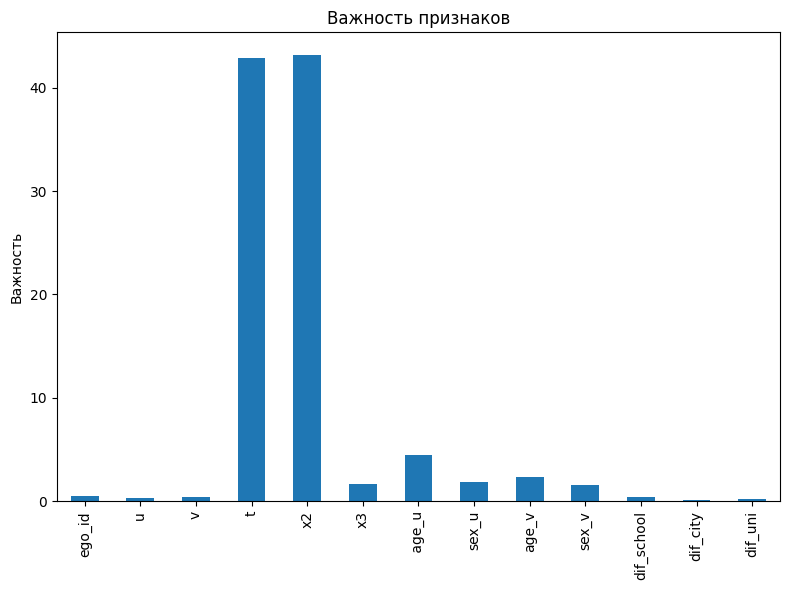

In [30]:
cb_model3_imp = pd.Series(cb_model3.feature_importances_,
                         X.columns)

fig, ax = plt.subplots(figsize=(8,6))
cb_model3_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


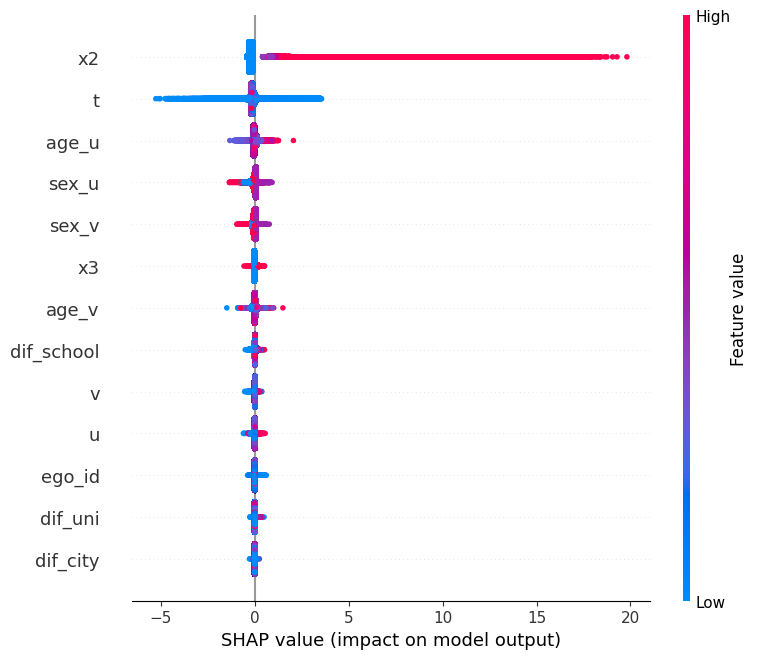

In [22]:
import shap 
shap_test = shap.TreeExplainer(cb_model_).shap_values(X)

shap.summary_plot(shap_test, X, max_display=15, auto_size_plot=True)

In [50]:
cb_model = CatBoostRegressor(random_state=42, metric_period=100, verbose=False, depth=16, rsm=0.98, 
                             learning_rate=0.01, l2_leaf_reg=3.7)

cb_model.fit(x_train, y_train)
y_pred = cb_model.predict(x_test)

metric = 1 - RMSE(y_test, y_pred)
score = cb_model.score(x_train, y_train)
print('CatBoostRegressor score: ', score)
print('1 - RMSE: ', metric)

CatBoostRegressor score:  0.724579534412349
1 - RMSE:  0.22597095757810493


In [65]:
cb_model1 = CatBoostRegressor(random_state=42, metric_period=100, verbose=False, depth=16, rsm=0.96, 
                             learning_rate=0.025, l2_leaf_reg=3.75)

cb_model1.fit(x_train, y_train)
y_pred1 = cb_model1.predict(x_test)

metric = 1 - RMSE(y_test, y_pred1)
score = cb_model1.score(x_train, y_train)
print('CatBoostRegressor score: ', score)
print('1 - RMSE: ', metric)
y_pred1

CatBoostRegressor score:  0.778103792706152
1 - RMSE:  0.23382238788428267


array([0.39832874, 0.29643613, 0.19718596, ..., 1.94974222, 0.58176967,
       0.62608247])

### -> Валидация